# **XXV Brazilian Symposium on Geoinformatics (GEOINFO 2025)**

Insituto Nacional de Pesquisas Espaciais \
Laboratório de Inteligência ARtificial para Aplicações AeroEspaciais e Ambientais (LIAREA) \
Instrutores: Mateus Miranda, Pedro Brito, e Rafael Marinho  \
Supervisor: Valdivino Alexandre Santiago


# 1 Introdução
O uso das *Convolutional Neural Networks* (CNN) têm sido frequemente usadas para detecção de foco de desmatamento, a partir de segmentação semântica. Essa técnica consiste em apresentar a U-Net exemplos de imagens, na posição X, e as máscaras de referências (mapa de desmatamento), na posição Y. Com isso, quando o modelo treinado receber imagens jamais vistas ele é avaliado quanto sua abilidade de , e partir disso poderá realizar outras tarefas, por exemplo, classificação. <br>
Dessa meneira, este projeto obejtiva usar uma CNN para segmentar imagens de radar a fim de identifcar áreas desmatadas, no contexto da foresta amazônica. O metodo de desenvolvimento é experimental, e a avaliação dos resultados é de cunho quanti-qualitativo. A seguir, será apresentado as seções 2. Metodologia, 2.1 biblioteca, 2.2 Dados, 2.2.1 Máscaras, 2.2.2 Recorte das imagens, 2.2.3 repartição dos dados, 2.2.4 Imagens e Tensores; 2.3 O modelo de segmentação; 2.4 Teste e avaliação, 2.4.1 Mosaico de imagens; 3. Considerações finais; e as referências.

## 1.2 Hands On
Este experimento se dá em preparação dos dados, treinamento e teste. A primeira etapa consiste em criar as máscaras a partir das imagens selecionadas para este projeto, recortar as imagens em partes iguais de 64 X 64 pixels, reparticiona-las em treinamento e teste e por fim transforma-las em tensores. O próximo passo é usar as imagens e suas respectivas máscaras, de treinamento, como entrada no modelo de segmentação. A última etapa, portanto, é usar as imagens de teste para avaliar a capacidade do modelo na tarefa de segmentação e, desse modo apresentar os resultados. Para tal, usou-se os pacotes:

### 1.2.1 Biblioteca

In [ ]:
# Instalando dependências
%pip install keras-unet
%pip install rasterio
%pip install kagglehub[pandas-datasets]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 100.6 MB/s eta 0:00:00


In [ ]:
# Leitura e pré-processamento de Dados
import cv2
import os
import PIL
import glob
import skimage
import numpy as np
import pandas as pd
from PIL import Image
from skimage import io
import tensorflow as tf
from PIL import ImageOps
import skimage.io as skio
import skimage.color as skc
import skimage.transform as skt
from keras.preprocessing import image
import sklearn.feature_extraction as skfe
from skimage import data, img_as_float, color
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import rasterio as rio
from sklearn.model_selection import train_test_split
from skimage.filters import threshold_otsu, threshold_local, gaussian
from osgeo import gdal

import kagglehub
from kagglehub import KaggleDatasetAdapter

# Machine Learning
import tensorflow as tf
from keras_unet.models import custom_unet
from keras_unet.models import vanilla_unet
from tensorflow.keras.preprocessing.image import load_img


import os
import glob
import numpy as np
import rasterio as rio
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence

# Gerar Gráficos
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.patches import Patch

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


### 1.2.2 Dados
O conjunto de dados que serão usados neste experimento ...

**Download o dataset**

In [ ]:
# Download latest version
path = kagglehub.dataset_download("cerranet/cerradatav31-for-semantic-segmentation")

print("Path to dataset files:", path)

100%|██████████| 552M/552M [00:07<00:00, 73.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/cerranet/cerradatav31-for-semantic-segmentation/versions/2


In [ ]:
# Move o dataset para o diretório principal
!mv /root/.cache/kagglehub/datasets/cerranet/cerradatav31-for-semantic-segmentation/versions/2 /content/

### 1.2.3 Carregamento de dados


In [ ]:
def data_info(modality):
    # SAR statistical information
    if modality == 'sar':
        min = [0.16844511032105, 0.18629205226898335]
        max = [1877.8493041992167, 1303.7864481607917]
        mean = [104.87897585598166, 95.52668271493417]
        stddev = [79.8024668186095, 63.256644370816836]

        return max, min, mean, stddev

    # MSI statistical information
    elif modality == 'msi':
        min = [99.78856658935547, 332.65665627643466, 347.161809168756, 331.4168453961611,
               196.89053159952164, 240.9765984416008, 261.34731489419937, 342.50664601475,
               277.87501442432404, 246.40860325098038, 265.9057685136795, 226.23770987987518]
        max = [7349.042938232482, 8987.99301147458, 8906.377044677738, 9027.435272216775,
               9090.25390625, 8949.610290527282, 8955.640045166012, 9491.945373535062,
               9026.07144165042, 11857.606872558594, 11817.384948730469, 13970.691894531188]
        mean = [1331.2999603920011, 1422.618248839035, 1648.7418838236356, 1811.0396095371318,
                2243.6360604171587, 2862.469356914663, 3158.7246770243464, 3253.5804747400075,
                3464.1887187200564, 3463.5260019211623, 3635.662557047575, 2740.6395025025904]
        stddev = [436.04697715189127, 484.32797096427566, 549.125419913045, 741.2668466992163,
                  788.8006282648606, 860.9668486457188, 963.2983618801512, 1000.2677835011111,
                  1087.111000434025, 1062.9960118331512, 1373.6088616321088, 1125.5168224477407]

        return max, min, mean, stddev

In [ ]:
CERRADATA3_CLASS_COLORS = {
    0: (112, 128, 144),     # Building
    1: (255, 165, 0),     # Cultivated Area
    2: (34, 139, 34),     # Forest
    3: (160, 32, 240),     # Non-Observed Area
    4: (160, 82, 45),     # Other uses
    5: (210, 180, 140),   # Pasture
    6: (154, 205, 50),    # Savanna Formation
    7: (0, 191, 255),     # Water
}

CERRADATA4_CLASS_COLORS = {
    0: (206, 239, 98),     # Pasture
    1: (22,152,13),    # Arboreal
    2: (230, 32, 108),   # Agriculture
    3: (176, 176, 176),  # Mining
    4: (223, 124, 38),   # Building
    5: (19, 50, 255),      # Water
    6: (117, 10, 194),   # Other uses
}

# Paleta de cores para cada classe da máscara
CLASS_COLORS = CERRADATA3_CLASS_COLORS

In [ ]:
def read_img(path):
    sar_img = gdal.Open(path)
    sar_i = sar_img.ReadAsArray()
    return sar_i

def normalizer(img_path, modality):
    # Data loader
    data = read_img(img_path)
    normalized = np.zeros(np.shape(data))

    # Avoid log(0)
    data = np.clip(data, a_min=1e-6, a_max=None)

    # Data information
    max, min, mean, stddev = data_info(modality=modality)


    #print('0 to 1 normalization')
    for j in range(len(data)):
        normalized[j] = (data[j] - min[j]) / (max[j] - min[j])
    return normalized


def _apply_colormap(mask):
    """
    Converte uma máscara (H, W, 1) de classes para RGB usando uma paleta fixa.
    """
    mask = mask.squeeze().astype(np.uint8)
    height, width = mask.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)

    for class_id, color in CLASS_COLORS.items():
        color_mask[mask == class_id] = color

    return color_mask

class CerraData4MMLoader:
    def __init__(self, base_path, patch_size=128, test_size=0.2, val_size=0.1, seed=42):
        self.base_path = base_path
        self.patch_size = patch_size
        self.test_size = test_size
        self.val_size = val_size
        self.seed = seed
        self._check_directory_structure()

    def _check_directory_structure(self):
        required_folders = ['images', 'reference_masks']
        for folder in required_folders:
            if not os.path.exists(os.path.join(self.base_path, folder)):
                raise FileNotFoundError(f"Pasta '{folder}' não encontrada no diretório base")

    def _load_and_process_image(self, raster_path, is_mask=False):
        if is_mask:
            mask = image.load_img(raster_path, target_size=(self.patch_size, self.patch_size), color_mode='grayscale')
            mask = image.img_to_array(mask)
            mask = mask.squeeze().astype(np.int32)
            mask = np.expand_dims(mask, axis=-1)
            return mask
        else:
            #img = normalizer(img_path=raster_path, modality='msi')
            #img = img.transpose(1, 2, 0)
            img = image.load_img(raster_path, target_size=(self.patch_size, self.patch_size), color_mode='rgb')
            img = image.img_to_array(img) / 255.0
            img = img.astype(np.float32)
            return img

    def _get_pairs(self):
        msi_images = sorted(glob.glob(os.path.join(self.base_path, 'images', '*.tif')))
        mask_images = sorted(glob.glob(os.path.join(self.base_path, 'reference_masks', '*.tif')))
        if len(msi_images) != len(mask_images):
            raise ValueError("Número de imagens e máscaras não corresponde")
        return msi_images, mask_images

    def get_dataset_paths(self):
        images_paths, mask_paths = self._get_pairs()
        train_imgs, test_imgs, train_masks, test_masks = train_test_split(
            images_paths, mask_paths, test_size=self.test_size, random_state=self.seed)
        train_imgs, val_imgs, train_masks, val_masks = train_test_split(
            train_imgs, train_masks, test_size=self.val_size, random_state=self.seed)
        return train_imgs, val_imgs, test_imgs, train_masks, val_masks, test_masks

    def visualize_samples(self, X, y, n_samples=3):
        plt.figure(figsize=(15, 5 * n_samples))

        for i in range(n_samples):
            idx = np.random.randint(0, len(X))
            image = X[idx]
            mask = y[idx]

            color_mask = _apply_colormap(mask)

            # Seleciona os canais 3, 2, 1 (índices 2, 1, 0 pois começa em 0)
            #rgb_image = image[..., [3, 2, 1]]#.transpose(1, 2, 0)  # ou image[2:0:-1] para pegar na ordem inversa

            # Ajuste da visualização (brilho e contraste)
            #rgb_image = np.clip(rgb_image * 2.5, 0, 1)  # Ajuste de brilho
            #rgb_image = rgb_image ** 0.8

            # Plots
            plt.subplot(n_samples, 3, i * 3 + 1)
            plt.imshow(image)
            plt.title(f"Imagem {idx}")
            plt.axis('off')

            plt.subplot(n_samples, 3, i * 3 + 2)
            plt.imshow(color_mask)
            plt.title("Máscara colorida")
            plt.axis('off')

            plt.subplot(n_samples, 3, i * 3 + 3)
            plt.imshow(image)
            plt.imshow(color_mask, alpha=0.4)
            plt.title("Sobreposição")
            plt.axis('off')

        # Legenda
        legend_elements = [
            Patch(facecolor=np.array(CLASS_COLORS[cid])/255.0, label=f"{cid}: {label}")
            for cid, label in zip(
                CLASS_COLORS.keys(),
                [
                    "Building", "Cultivated Area", "Forest", "Non-Observed Area", "Other Uses", "Pasture", "Savanna Formation", "Water"
                ]
            )
        ]

        plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.02),
                   ncol=4, frameon=False)
        plt.tight_layout()
        plt.show()

class CerraDataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, patch_size=256, batch_size=16, shuffle=True, loader_instance=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.shuffle = shuffle
        self.loader = loader_instance
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_img_paths = [self.image_paths[k] for k in indexes]
        batch_mask_paths = [self.mask_paths[k] for k in indexes]

        X = [self.loader._load_and_process_image(p) for p in batch_img_paths]
        y = [self.loader._load_and_process_image(p, is_mask=True) for p in batch_mask_paths]

        return np.array(X), np.array(y)


 "Building", "Cultivated Area", "Forest", "Non-Observed Area",
                    "Other Uses", "Pasture", "Savanna Formation", "Water"

**Carrega o dataset**

In [ ]:
# Configurações
DATASET_PATH = "/content/2/cerradatav3_1/cerradatav3_1/"  # tem 'images' e 'reference_masks'

# Inicialização
loader = CerraData4MMLoader(
    base_path=DATASET_PATH,
    patch_size=128,
    test_size=0.2,
    val_size=0.1,
    seed=42
)

# Dividir em caminhos
train_imgs, val_imgs, test_imgs, train_masks, val_masks, test_masks = loader.get_dataset_paths()

# Criar generators
train_gen = CerraDataGenerator(train_imgs, train_masks, batch_size=16, loader_instance=loader)
val_gen = CerraDataGenerator(val_imgs, val_masks, batch_size=16, loader_instance=loader)
test_gen = CerraDataGenerator(test_imgs, test_masks, batch_size=16, loader_instance=loader)


**Visualizar as imagens**

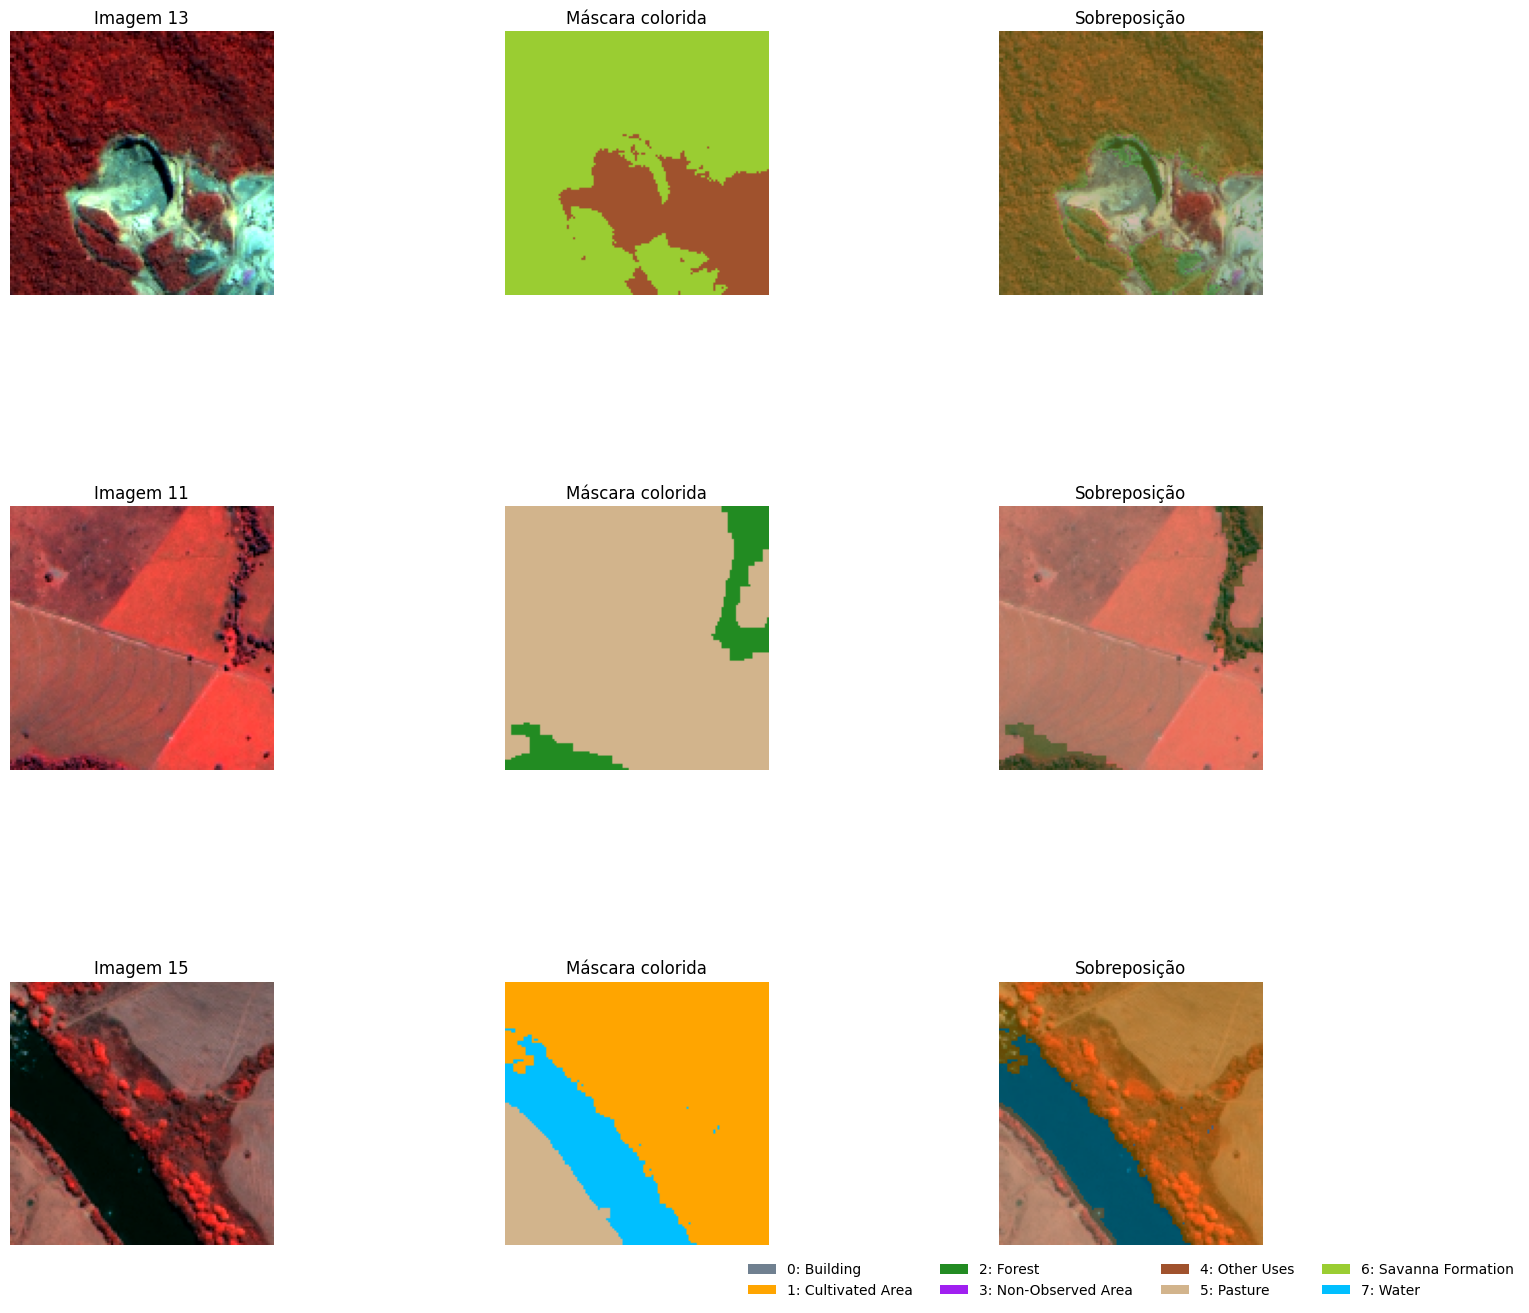

In [ ]:
X_sample, y_sample = train_gen[0]  # primeiro batch
loader.visualize_samples(X_sample, y_sample, n_samples=3)

### Analisando o dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def analyze_dataset(dataset_gen, class_colors=CLASS_COLORS, title="Distribuição do Dataset"):
    """
    Analisa o dataset e plota a distribuição das classes

    Args:
        dataset_gen: Gerador de dados (deve retornar (X, y))
        class_colors: Dicionário com cores para cada classe
        title: Título do gráfico
    """
    class_counts = defaultdict(int)
    total_pixels = 0
    image_shapes = set()
    unique_values = set()

    # Iterar por todos os batches do dataset
    for i in range(len(dataset_gen)):
        _, y_batch = dataset_gen[i]
        y_batch = y_batch.squeeze()  # Remove dimensão extra se existir

        # Coletar estatísticas
        image_shapes.add(y_batch.shape[1:])  # Formato das imagens
        unique_values.update(np.unique(y_batch))  # Valores únicos encontrados

        # Contar pixels por classe
        for class_id in class_colors.keys():
            class_counts[class_id] += np.sum(y_batch == class_id)
            total_pixels += np.sum(y_batch == class_id)

    # Converter contagens para percentuais
    class_percentages = {k: (v / total_pixels * 100) for k, v in class_counts.items()}

    # Plotar distribuição
    plt.figure(figsize=(12, 6))

    # Gráfico de barras
    plt.subplot(1, 2, 1)
    bars = plt.bar(class_percentages.keys(), class_percentages.values(),
                  color=[np.array(class_colors[k])/255.0 for k in class_percentages.keys()])
    plt.title('Distribuição Percentual por Classe')
    plt.xlabel('Classes')
    plt.ylabel('Percentual de Pixels (%)')

    # Adicionar valores nas barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')

    # Gráfico de pizza
    plt.subplot(1, 2, 2)
    patches, texts, autotexts = plt.pie(class_percentages.values(),
                                       labels=class_percentages.keys(),
                                       colors=[np.array(class_colors[k])/255.0 for k in class_percentages.keys()],
                                       autopct='%1.1f%%',
                                       startangle=90)
    plt.title('Distribuição em Pizza')
    plt.axis('equal')  # Assegura que o pie é desenhado como um círculo

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    # Imprimir informações adicionais
    print("\nInformações Adicionais:")
    print(f"Total de pixels analisados: {total_pixels}")
    print(f"Formatos de imagem encontrados: {image_shapes}")
    print(f"Valores únicos encontrados: {sorted(unique_values)}")
    print("\nDistribuição por classe (absoluta/percentual):")
    for class_id in sorted(class_colors.keys()):
        print(f"Classe {class_id}: {class_counts[class_id]} pixels ({class_percentages[class_id]:.2f}%)")

    return class_counts, class_percentages

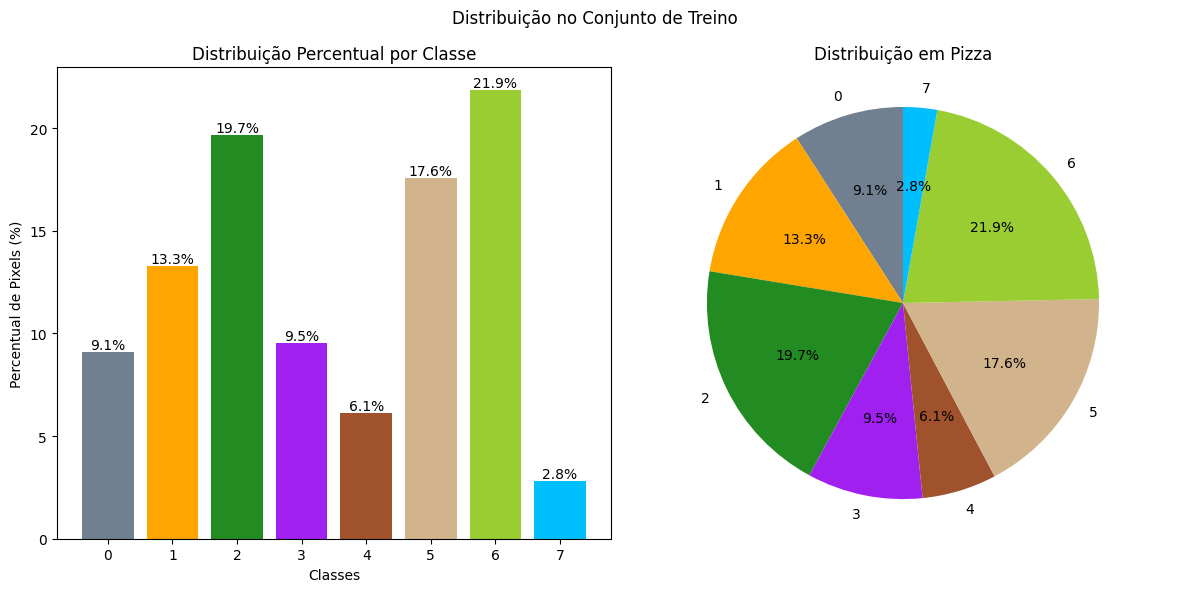


Informações Adicionais:
Total de pixels analisados: 18825216
Formatos de imagem encontrados: {(128, 128)}
Valores únicos encontrados: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7)]

Distribuição por classe (absoluta/percentual):
Classe 0: 1716043 pixels (9.12%)
Classe 1: 2501900 pixels (13.29%)
Classe 2: 3702890 pixels (19.67%)
Classe 3: 1792469 pixels (9.52%)
Classe 4: 1156238 pixels (6.14%)
Classe 5: 3310033 pixels (17.58%)
Classe 6: 4116854 pixels (21.87%)
Classe 7: 528789 pixels (2.81%)


In [ ]:
# 1. Analisar o dataset
class_counts, class_percentages = analyze_dataset(train_gen, title="Distribuição no Conjunto de Treino")

## 2.3 O modelo segmentador
A arquitetura CNN usada neste experimento é uma adaptação da rede U-net, antes desenvolvido por Olaf Ronneberger, Philipp Fischer, e Thomas Brox em 2015, projetada por [Żak, K., 2019]. O modelo recebe uma entrada de `64,63,3`, que corresponde às dismensões das imagens, as camadas convolucionais são ativada pela função `relu`, exceto a camada de saída, sendo ela ativada pela função `sigmoid`. As taxas de ganho e perda são aferidas, respectivamente, por `erro quadrático médio` e `accuracy`, otimizados pela função `adam`. Ainda, foi definido que 20% das entradas serão usadas para validação dos pesos, durante o treinamento.

In [ ]:
# Definindo o modelo
model = custom_unet(
    input_shape=(128, 128, 3),
    use_batch_norm=False,
    num_classes=8,
    filters=128,
    dropout=0.15,
    output_activation='softmax') # Softmax

# Compilador
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Treinamento
history = model.fit(train_gen, epochs=40,
                    validation_data=val_gen)

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_37']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


72/72 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.1855 - loss: 5.8767 - val_accuracy: 0.2641 - val_loss: 1.6984
Epoch 2/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 50s 698ms/step - accuracy: 0.3627 - loss: 1.5832 - val_accuracy: 0.4687 - val_loss: 1.3718
Epoch 3/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 51s 704ms/step - accuracy: 0.4853 - loss: 1.4547 - val_accuracy: 0.4578 - val_loss: 1.5242
Epoch 4/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 50s 692ms/step - accuracy: 0.4442 - loss: 1.5781 - val_accuracy: 0.5198 - val_loss: 1.3383
Epoch 5/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 49s 686ms/step - accuracy: 0.5104 - loss: 1.3435 - val_accuracy: 0.5604 - val_loss: 1.2639
Epoch 6/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 694ms/step - accuracy: 0.5580 - loss: 1.2333 - val_accuracy: 0.5869 - val_loss: 1.2231
Epoch 7/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 49s 684ms/step - accuracy: 0.5778 - loss: 1.1843 - val_accuracy: 0.5855 - val_loss: 1.1654
Epoch 8/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 50s 691ms/step - accuracy: 0.5951 - loss: 1.1498 - val_accuracy: 0.5911 

**Histórico do treinamento**

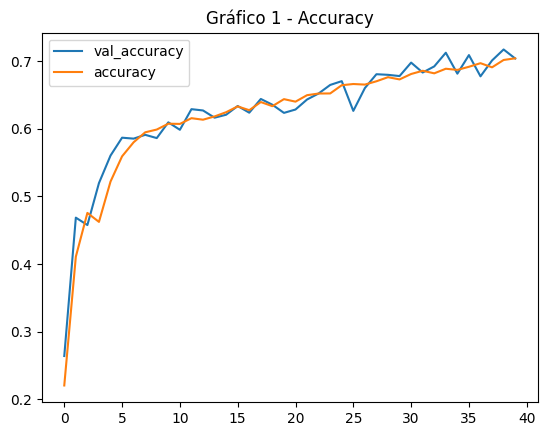

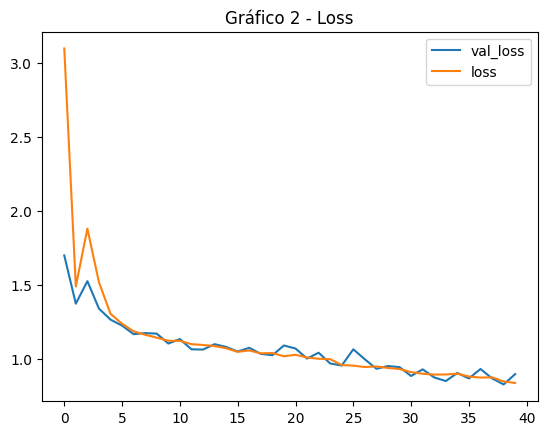

In [ ]:
# Visualizando o resultado do treinamento
losses = pd.DataFrame(model.history.history)[['val_accuracy','accuracy']]
losses.plot()
plt.title("Gráfico 1 - Accuracy")
plt.show()
losses = pd.DataFrame(model.history.history)[['val_loss','loss']]
losses.plot()
plt.title("Gráfico 2 - Loss")
plt.show()

**Salva o modelo treinado**

In [ ]:
from datetime import datetime
import os

# Criar diretório para salvar os modelos se não existir
model_dir = "saved_models"
os.makedirs(model_dir, exist_ok=True)

# Gerar nome único para o modelo com extensão .keras
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"cerra_unet_model_{timestamp}.keras"  # Adicionando extensão .keras
model_path = os.path.join(model_dir, model_name)

# Salvar o modelo completo (arquitetura + pesos + otimizador)
model.save(model_path)

# Opção alternativa para salvar no formato .h5
h5_model_name = f"cerra_unet_model_cerradata3_{timestamp}.h5"
h5_model_path = os.path.join(model_dir, h5_model_name)
model.save(h5_model_path)

print(f"Modelo salvo em formato Keras (.keras): {model_path}")
print(f"Modelo salvo em formato HDF5 (.h5): {h5_model_path}")

Modelo salvo em formato Keras (.keras): saved_models/cerra_unet_model_20250518_150036.keras
Modelo salvo em formato HDF5 (.h5): saved_models/cerra_unet_model_cerradata3_20250518_150036.h5


In [ ]:
from tensorflow.keras.models import load_model

def load_saved_model(model_path):
    """Carrega um modelo salvo"""
    try:
        model = load_model(model_path)
        print(f"Modelo carregado com sucesso de: {model_path}")
        return model
    except Exception as e:
        print(f"Erro ao carregar o modelo: {e}")
        return None

In [ ]:
model_path = '/content/saved_models/cerra_unet_model_cerradata3_20250518_150036.h5'
# Carregar o modelo .keras (recomendado)
loaded_model = load_saved_model(model_path)

# Ou carregar o modelo .h5
# loaded_model = load_saved_model(h5_model_path)

Modelo carregado com sucesso de: /content/saved_models/cerra_unet_model_cerradata3_20250518_150036.h5


## 2.4 Teste e avaliação do modelo
O teste e avaliação do modelo consistem em utilizar os métodos `model.predict()` e `model.evaluate()` que, apartir do modelo treinado, faz a previsão da posição de cada classe na imagem 'real' e assim segmenta-a, enquanto que o segundo método compara todas as máscaras desejadas, de suas respectivas imagens, com as imagens segmentadas pelo modelo.

In [ ]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

def visualize_test_results(model, test_gen, num_samples=3, batch_index=0):
    """
    Visualiza resultados do teste com máscaras coloridas e métricas

    Args:
        model: Modelo treinado
        test_gen: Gerador de dados de teste
        num_samples: Número de amostras para visualizar
        batch_index: Índice do batch a ser visualizado
    """
    # Obter um batch de dados
    X_batch, y_true_batch = test_gen[batch_index]

    # Fazer previsões
    y_pred_batch = model.predict(X_batch)

    # Converter predições em classes (se for saída multiclasse)
    if y_pred_batch.shape[-1] > 1:
        y_pred_batch = np.argmax(y_pred_batch, axis=-1)
        y_pred_batch = np.expand_dims(y_pred_batch, axis=-1)
    else:
        y_pred_batch = (y_pred_batch > 0.5).astype(np.int32)

    # Configurar figura
    plt.figure(figsize=(18, 5*num_samples))

    for i in range(min(num_samples, len(X_batch))):
        # Obter amostras
        image = X_batch[i]
        true_mask = y_true_batch[i].squeeze()
        pred_mask = y_pred_batch[i].squeeze()

        # Aplicar colormap
        true_mask_rgb = _apply_colormap(true_mask)
        pred_mask_rgb = _apply_colormap(pred_mask)

        # Calcular métricas para esta amostra
        iou_scores = {}
        for class_id in CLASS_COLORS.keys():
            true_class = (true_mask == class_id)
            pred_class = (pred_mask == class_id)

            if np.sum(true_class) > 0 or np.sum(pred_class) > 0:
                intersection = np.logical_and(true_class, pred_class)
                union = np.logical_or(true_class, pred_class)
                iou_scores[class_id] = np.sum(intersection) / (np.sum(union) + 1e-7)

        # Plotar
        # Seleciona os canais 3, 2, 1 (índices 2, 1, 0 pois começa em 0)
        #image = image[..., [3, 2, 1]]#.transpose(1, 2, 0)  # ou image[2:0:-1] para pegar na ordem inversa

        # Ajuste da visualização (brilho e contraste)
        #image = np.clip(image * 2.5, 0, 1)  # Ajuste de brilho
        #image = image ** 0.8

        # Imagem original
        plt.subplot(num_samples, 4, i*4 + 1)
        plt.imshow(image)
        plt.title(f'Imagem {i+1}')
        plt.axis('off')

        # Máscara verdadeira
        plt.subplot(num_samples, 4, i*4 + 2)
        plt.imshow(true_mask_rgb)
        plt.title('Máscara Verdadeira')
        plt.axis('off')

        # Máscara prevista
        plt.subplot(num_samples, 4, i*4 + 3)
        plt.imshow(pred_mask_rgb)
        plt.title('Máscara Prevista')
        plt.axis('off')

        # Sobreposição
        plt.subplot(num_samples, 4, i*4 + 4)
        plt.imshow(image)
        plt.imshow(pred_mask_rgb, alpha=0.4)
        plt.title('Sobreposição (IoU por classe)')

        # Adicionar métricas como texto
        metrics_text = "\n".join([f"Classe {k}: {v:.2f}" for k, v in iou_scores.items()])
        plt.text(0.5, -0.2, metrics_text,
                 ha='center', va='center',
                 transform=plt.gca().transAxes,
                 bbox=dict(facecolor='white', alpha=0.8))
        plt.axis('off')

    # Criar legenda
    legend_patches = []
    for class_id, color in CLASS_COLORS.items():
        legend_patches.append(mpatches.Patch(
            color=np.array(color)/255.0,
            label=f'Classe {class_id}'
        ))

    plt.figlegend(
        handles=legend_patches,
        loc='lower center',
        ncol=len(CLASS_COLORS),
        bbox_to_anchor=(0.5, -0.05)
    )

    plt.tight_layout()
    plt.show()

# Função auxiliar para calcular métricas de avaliação
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np

def evaluate_model(model, test_gen):
    """
    Avalia o modelo no conjunto de teste e retorna métricas agregadas

    Returns:
        dict: Dicionário com métricas de avaliação
    """
    iou_scores = {k: [] for k in CLASS_COLORS.keys()}
    accuracy_scores = []
    all_true = []
    all_pred = []

    for batch_idx in range(len(test_gen)):
        X_batch, y_true_batch = test_gen[batch_idx]
        y_pred_batch = model.predict(X_batch)

        if y_pred_batch.shape[-1] > 1:
            y_pred_batch = np.argmax(y_pred_batch, axis=-1)
        else:
            y_pred_batch = (y_pred_batch > 0.5).astype(np.int32)

        y_true_batch = y_true_batch.squeeze()

        # Armazenar para cálculo agregado
        all_true.extend(y_true_batch.flatten())
        all_pred.extend(y_pred_batch.flatten())

        # Calcular métricas por classe
        for class_id in CLASS_COLORS.keys():
            true_class = (y_true_batch == class_id)
            pred_class = (y_pred_batch == class_id)

            intersection = np.logical_and(true_class, pred_class)
            union = np.logical_or(true_class, pred_class)

            iou = np.sum(intersection) / (np.sum(union) + 1e-7)
            iou_scores[class_id].append(iou)

        # Acurácia geral
        accuracy = np.mean(y_true_batch == y_pred_batch)
        accuracy_scores.append(accuracy)

    # Converter para arrays numpy
    all_true = np.array(all_true)
    all_pred = np.array(all_pred)

    # Calcular F1-score por classe e macro/micro averages
    f1_per_class = f1_score(all_true, all_pred, average=None, labels=list(CLASS_COLORS.keys()))
    f1_scores = {
        'per_class': {class_id: score for class_id, score in zip(CLASS_COLORS.keys(), f1_per_class)},
        'macro': f1_score(all_true, all_pred, average='macro'),
        'micro': f1_score(all_true, all_pred, average='micro')
    }

    # Calcular matriz de confusão
    conf_matrix = confusion_matrix(all_true, all_pred, labels=list(CLASS_COLORS.keys()))

    # Calcular médias
    results = {
        'mean_accuracy': np.mean(accuracy_scores),
        'class_iou': {k: np.mean(v) for k, v in iou_scores.items()},
        'mean_iou': np.mean([np.mean(v) for v in iou_scores.values()]),
        'f1_scores': f1_scores,
        'confusion_matrix': conf_matrix.tolist(),  # Converter para lista para serialização
        'confusion_matrix_classes': list(CLASS_COLORS.keys())  # Ordem das classes na matriz
    }

    return results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


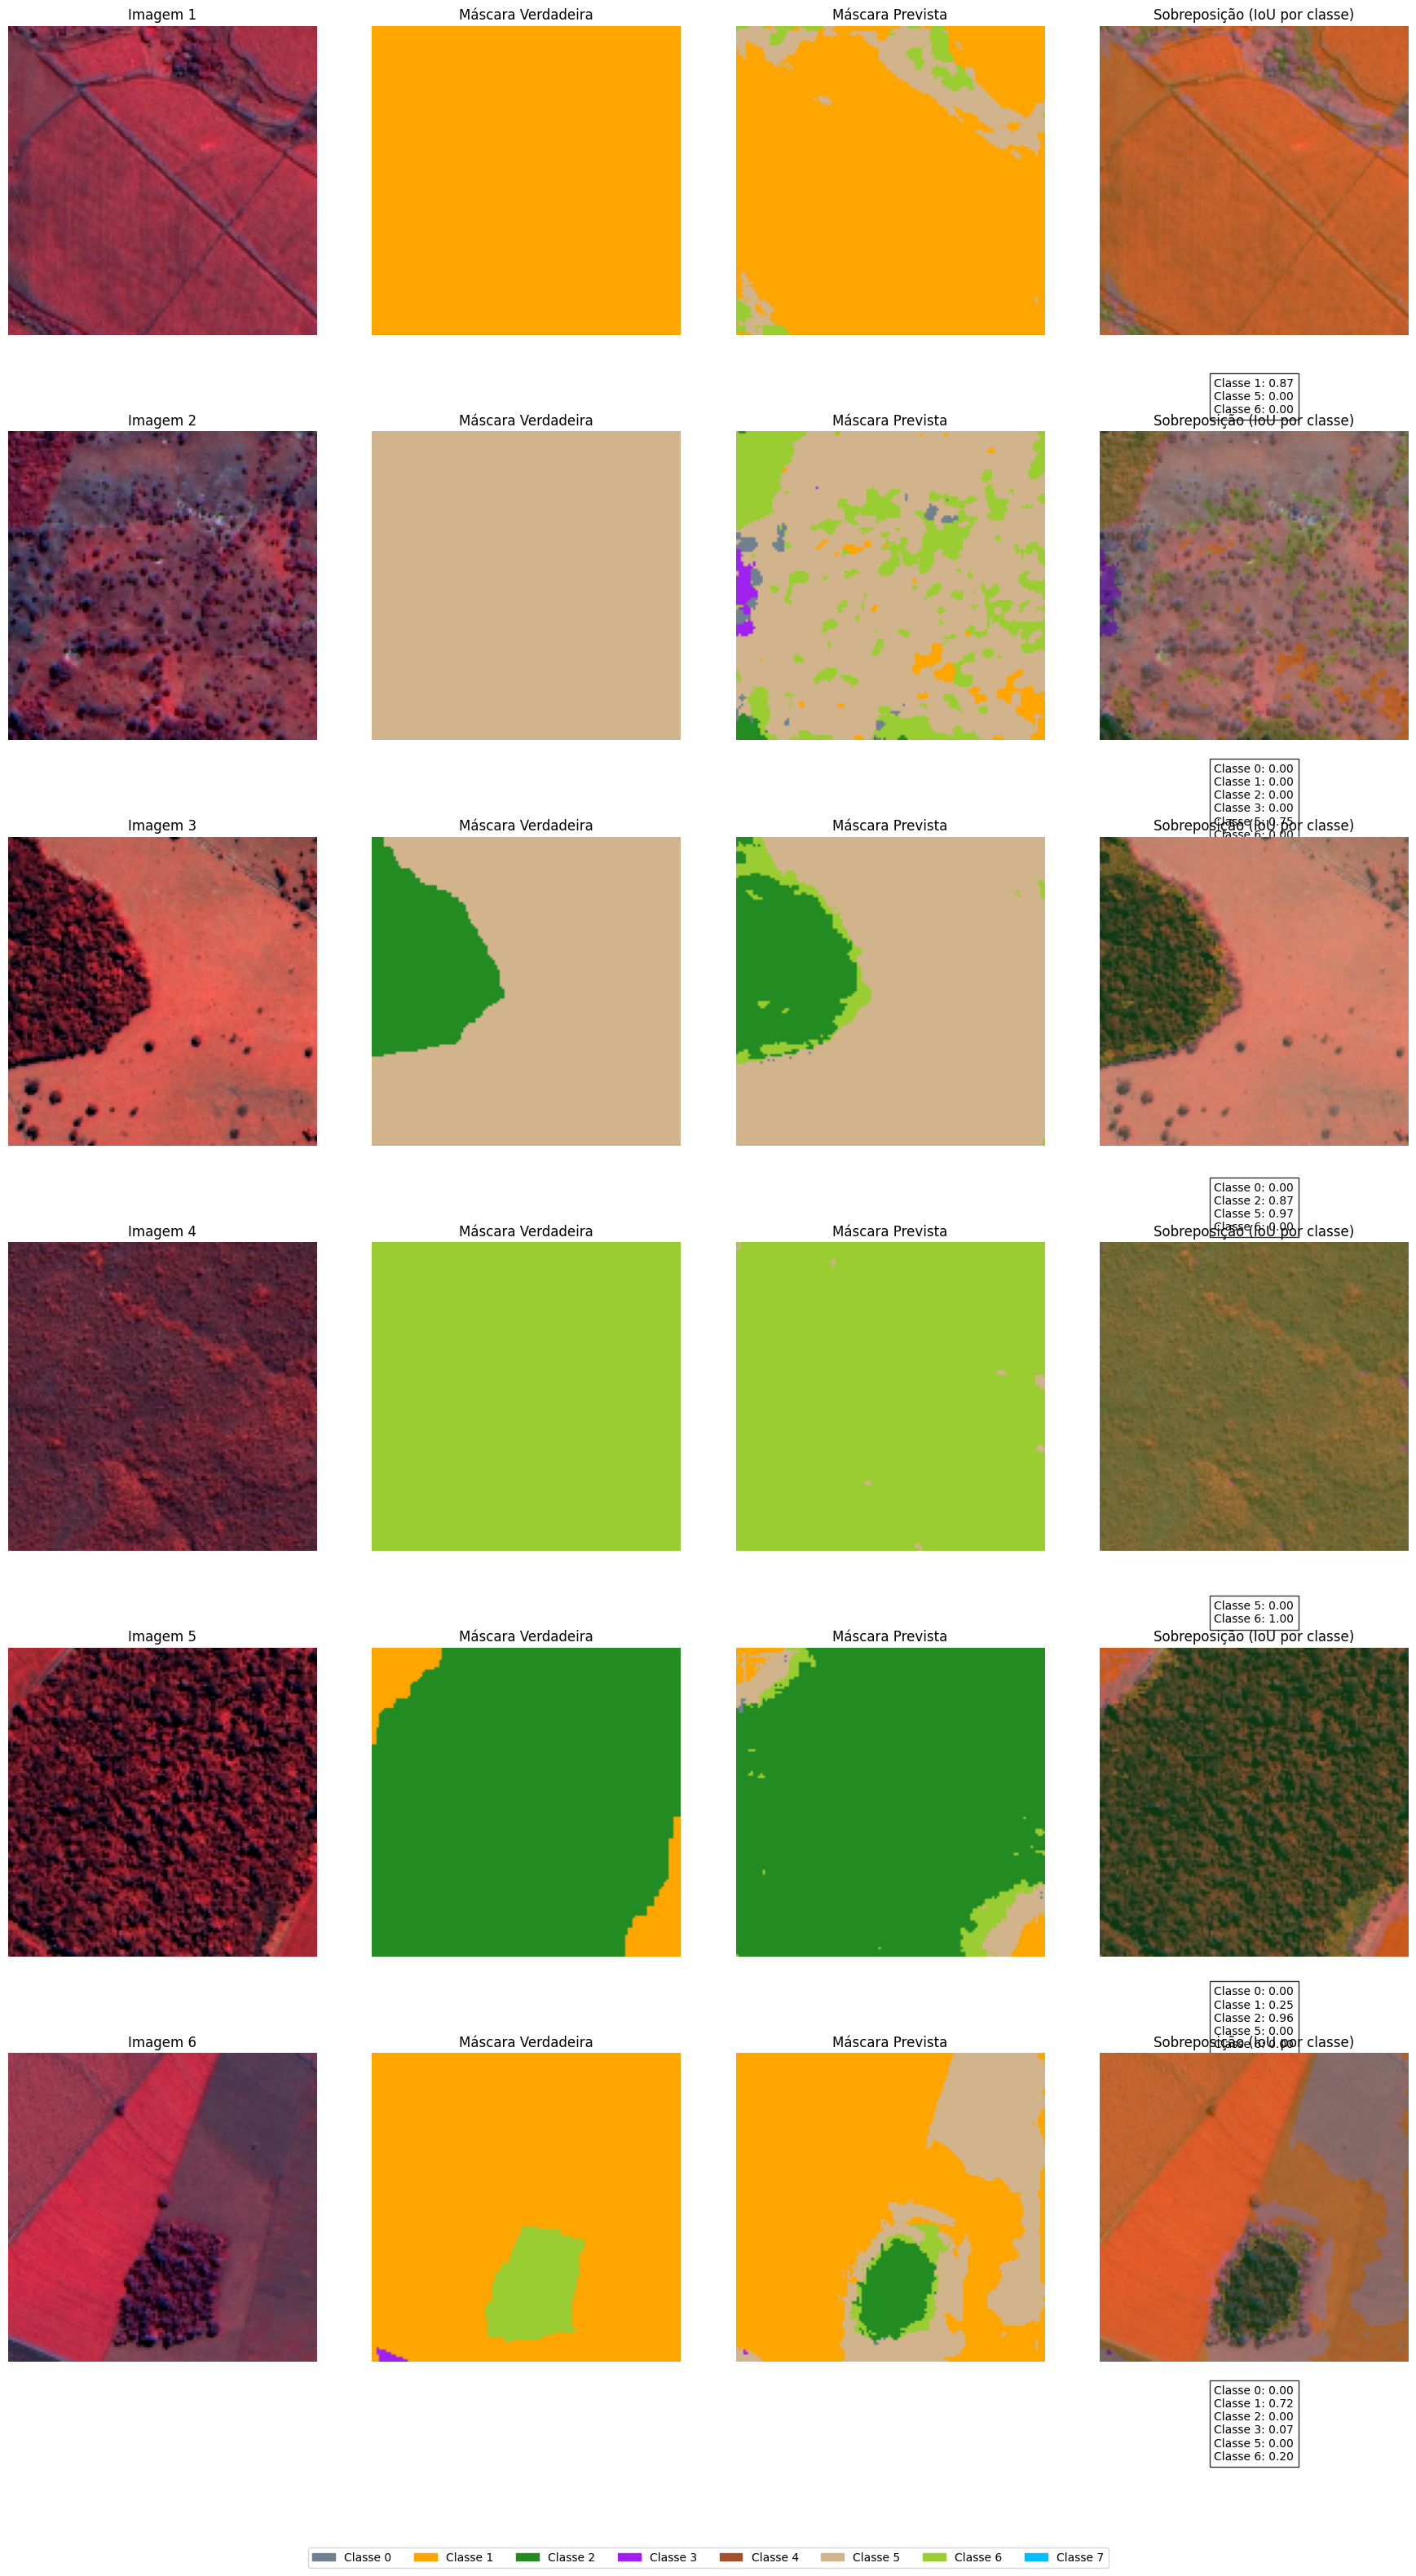

In [ ]:
# 1. Visualizar resultados
visualize_test_results(loaded_model, test_gen, num_samples=6)



In [ ]:
# 2. Avaliação completa
metrics = evaluate_model(loaded_model, test_gen)

print("\nMétricas de avaliação:")
print(f"Acurácia média: {metrics['mean_accuracy']:.4f}")
print("\nF1-scores:")
print(f"  Macro F1: {metrics['f1_scores']['macro']:.4f}")
print("\nF1 por classe:")
for class_id, f1 in metrics['f1_scores']['per_class'].items():
    print(f"  Classe {class_id}: {f1:.4f}")

print(f"\nIoU médio: {metrics['mean_iou']:.4f}")
print("\nIoU por classe:")
for class_id, iou in metrics['class_iou'].items():
    print(f"  Classe {class_id}: {iou:.4f}")

print("\nMatriz de confusão:")
print("Classes:", metrics['confusion_matrix_classes'])
# Imprimir a matriz de confusão de forma formatada
print("Matriz:")
for row in metrics['confusion_matrix']:
    print("  " + " ".join(f"{val:5}" for val in row))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step

Métricas de avaliação:
Acurácia média: 0.7342

F1-scores:
  Macro F1: 0.7197

F1 por classe:
  Classe 0: 0.7629
  Classe 1: 0.7786
  Classe 2: 0.8610
  Classe 3: 0.7435
  Classe 4: 0.5390
  Classe 5: 0.5834
  Classe 6: 

In [ ]:
!zip -r saved_models_cerradata3 /content/saved_models/

  adding: content/saved_models/ (stored 0%)
  adding: content/saved_models/cerra_unet_model_cerradata3_20250518_150036.h5 (deflated 35%)
  adding: content/saved_models/cerra_unet_model_20250518_150036.keras (deflated 35%)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.download('/content/saved_models_cerradata3.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Referências
[Żak, K., 2019] Unet. https://github.com/karolzak/keras-unet <br>
[Sciit-image] General  purpose imagens. https://scikit-image.org/docs/stable/auto_examples/data/plot_general.html#sphx-glr-auto-examples-data-plot-general-py